## Initial code

In [1]:
import os
import sys


curr_dir = os.getcwd()
parent_dir = os.path.dirname(curr_dir)
sys.path.append(parent_dir)


import psutil
from utils import check_and_install
    
# List of packages to check, with any special names or setup functions
packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "scipy",
    "tqdm",
    "pandarallel",
    "thinc",
    "srsly",
    "fastai"
]

# Loop through each package, importing and installing if needed
for package in packages:
    check_and_install(package)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool



from pandarallel import pandarallel

real_cpu_count = psutil.cpu_count(logical=False)
pandarallel.initialize(progress_bar=True)


scikit-learn not found, installing...
scikit-learn has been installed
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
DatasetRaces = pd.read_csv("../dataset/races_filled.csv")
DatasetCyclists = pd.read_csv("../dataset/cyclists_filled.csv")

MergedDataset = pd.merge(DatasetCyclists, DatasetRaces.drop(columns=['name']), left_on='_url', right_on='cyclist', suffixes=('_cyclist', '_race')).drop(columns=['_url_cyclist']) 
del MergedDataset['race_year']

print(MergedDataset.duplicated().sum())
print(MergedDataset.isnull().sum())

MergedDataset.sample(3)


0
name                      0
birth_year                0
weight                    0
height                    0
nationality               0
expected_url              0
_url_race                 0
points                    0
uci_points                0
length                    0
climb_total               0
profile                   0
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age               0
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team         158681
delta                     0
dtype: int64


,name,birth_year,weight,height,nationality,expected_url,_url_race,points,uci_points,length,...,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
543261,José Luis Arrieta,1971.0,68.0,178.0,Spain,jose-luis--arrieta,giro-d-italia/1999/stage-12,0.0,0.0,168000.0,...,1057,1999-05-26 04:07:07,30,jose-luis-arrieta,28.0,True,False,False,team-saxo-bank-tinkoff-bank-2012,4.0
272806,Pascal Hervé,1964.0,62.0,169.0,France,pascal--herve,vuelta-a-espana/1999/stage-8,0.0,0.0,175600.0,...,1342,1999-09-12 05:24:20,141,pascal-herve,35.0,True,False,False,NaN,1936.0
85619,Luca Mazzanti,1974.0,64.0,170.0,Italy,luca--mazzanti,giro-d-italia/2006/stage-17,0.0,0.0,210000.0,...,997,2006-05-25 05:34:30,82,luca-mazzanti,32.0,True,False,False,liberty-seguros-wurth-team-2005,177.0


In [3]:
outliers_lof = pd.read_csv('../dataset/outliers_lof.csv')
outliers_iso_for = pd.read_csv('../dataset/outliers_iso_for.csv')
outliers_oc_svm_gpu = pd.read_csv('../dataset/outliers_oc_svm.csv')

normal_lof = MergedDataset[~MergedDataset['_url_race'].isin(outliers_lof['name_race'])]
normal_iso_for = MergedDataset[~MergedDataset['_url_race'].isin(outliers_iso_for['name_race'])]
normal_oc_svm = MergedDataset[~MergedDataset['_url_race'].isin(outliers_oc_svm_gpu['name_race'])]

normal_lof_num = normal_lof.select_dtypes(include=[np.number])
normal_iso_for_num = normal_iso_for.select_dtypes(include=[np.number])
normal_oc_svm_num = normal_oc_svm.select_dtypes(include=[np.number])

outliers_lof_num = outliers_lof.select_dtypes(include=[np.number])
outliers_iso_for_num = outliers_iso_for.select_dtypes(include=[np.number])
outliers_oc_svm_num = outliers_oc_svm_gpu.select_dtypes(include=[np.number])

normal_lof.sample(3)

,name,birth_year,weight,height,nationality,expected_url,_url_race,points,uci_points,length,...,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
208635,Eros Capecchi,1986.0,65.0,183.0,Italy,eros--capecchi,giro-d-italia/2013/stage-14,0.0,0.0,181000.0,...,930,2013-05-18 04:46:16,26,eros-capecchi,27.0,True,False,False,spain-1970,201.0
119401,Laurent Dufaux,1969.0,60.0,169.0,Switzerland,laurent--dufaux,amstel-gold-race/2000/result,70.0,160.0,257000.0,...,1352,2000-04-22 06:13:37,6,laurent-dufaux,31.0,False,False,False,kelme-costa-blanca-2000,7.0
575996,Stéphane Goubert,1970.0,62.0,178.0,France,stephane--goubert,dauphine/2007/stage-3,0.0,0.0,40700.0,...,816,2007-06-13 00:56:27,56,stephane-goubert,37.0,True,False,False,c-a-1978,259.0


## Outliers analysis

Since each run of the algorithms might produce different parameters and different outliers, we will use the outliers generated by the main notebook.

### Z-scores, box plots

In [5]:
from outliers_code.outliers_analysis import (
    calculate_z_score, 
    plot_outlier_scores, 
    plot_z_score_distributions,    
)

NumericalDataset = normal_lof.select_dtypes(include=[np.number])
del NumericalDataset['race_year']
stats = NumericalDataset.agg(['mean', 'std'])
data_mean, data_std = stats.loc['mean'], stats.loc['std']



data_tuples = [
    (outliers_lof[NumericalDataset.columns], data_mean, data_std),
    (outliers_iso_for[NumericalDataset.columns], data_mean, data_std),
    (outliers_oc_svm_gpu[NumericalDataset.columns], data_mean, data_std)
]
with Pool() as pool:
    z_scores = pool.map(calculate_z_score, data_tuples)

z_scores_lof, z_scores_iso_for, z_scores_oc_svm = z_scores



#### Histogram plots of outliers z-scores

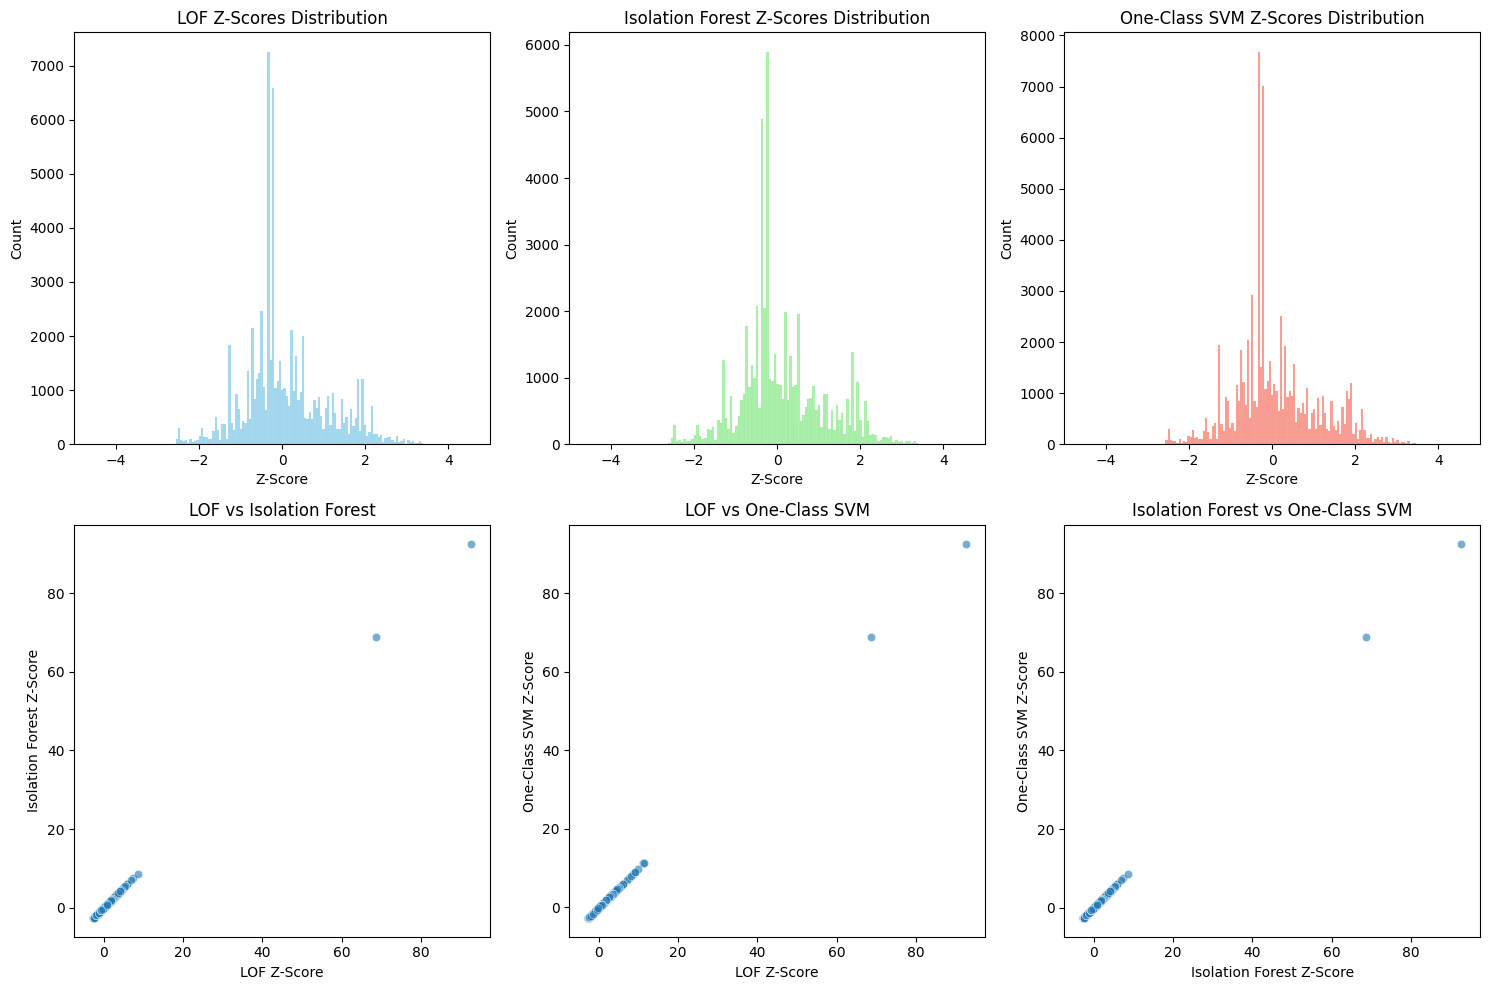

In [5]:
plot_outlier_scores(z_scores_lof, z_scores_iso_for, z_scores_oc_svm)

#### Box plots of outliers z-scores

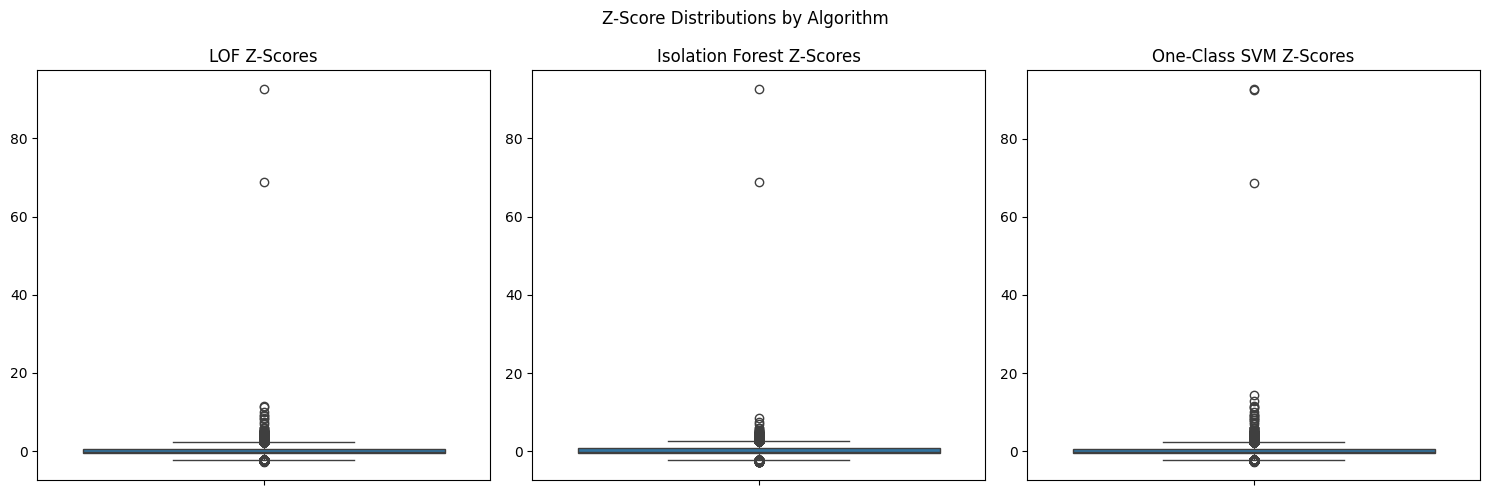

In [6]:
z_scores_dict = {
    "LOF": z_scores_lof,
    "Isolation Forest": z_scores_iso_for,
    "One-Class SVM": z_scores_oc_svm
}

plot_z_score_distributions(z_scores_dict)

### KDE plots

/home/lesi-nedo/Desktop/master/second-year/first-semester/DM/DataMining-unipi-24-25-M/outliers_code/outliers_analysis.py:135: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=inliers, ax=ax, label='Inliers', color='blue', bw_adjust=0.5)


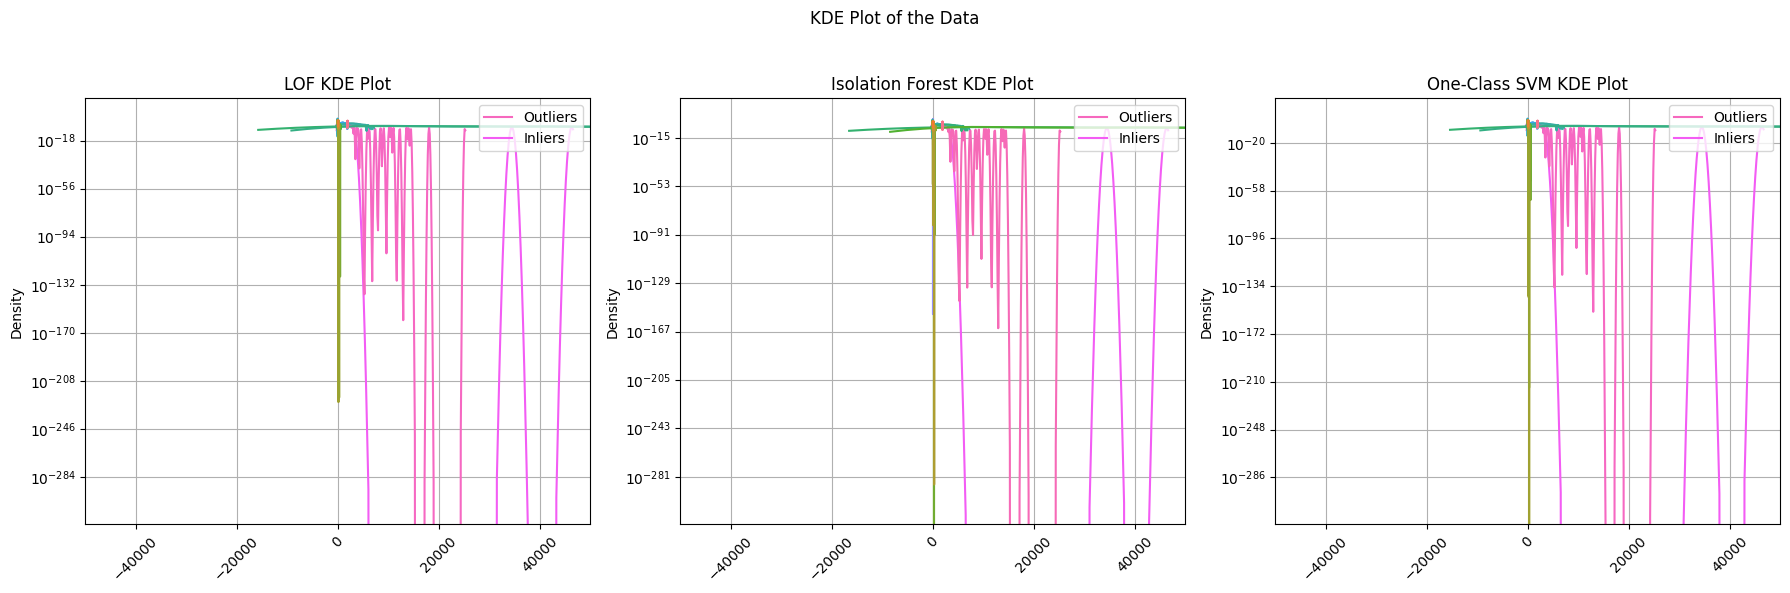

In [4]:
from outliers_code.outliers_analysis import plot_kdes

df_dicts = {
    'LOF': (outliers_lof_num,normal_lof_num),
    'Isolation Forest': (outliers_iso_for_num, normal_iso_for),
    'One-Class SVM': (outliers_oc_svm_num, normal_oc_svm_num)
}
plot_kdes(df_dicts)